In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_and_preprocess_data(data_path):
    all_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.csv')]
    df_list = []
    for file in all_files:
        df = pd.read_csv(file, encoding='latin1')
        df.columns = df.columns.str.strip()
        df_list.append(df)
    
    full_df = pd.concat(df_list, ignore_index=True)
    
    # 무한대 값을 NaN으로 바꾸고, NaN 값을 포함하는 행 제거
    full_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    full_df.dropna(inplace=True)
    
    # 숫자형이 아닌 열과 레이블 열 제외
    numeric_cols = full_df.select_dtypes(include=np.number).columns.tolist()
    
    # 정상 데이터만 선택
    benign_df = full_df[full_df['Label'] == 'BENIGN']
    attack_df = full_df[full_df['Label'] != 'BENIGN']
    
    # 스케일링
    scaler = StandardScaler()
    benign_scaled = scaler.fit_transform(benign_df[numeric_cols])
    attack_scaled = scaler.transform(attack_df[numeric_cols])
    
    return benign_scaled, attack_scaled, benign_df, attack_df, numeric_cols, scaler

data_path = 'dataset/'
benign_data, attack_data, benign_df, attack_df, numeric_cols, scaler = load_and_preprocess_data(data_path)

C:\Users\csp\AppData\Local\Temp\ipykernel_8996\3070904689.py:5: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, encoding='latin1')


In [3]:
## Autoencoder
input_dim = benign_data.shape[1]
encoding_dim = 32

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="sigmoid")(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history = autoencoder.fit(benign_data, benign_data,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_split=0.2,
                verbose=1)


Epoch 1/50
7098/7098 [==============================] - 11s 2ms/step - loss: 0.6929 - val_loss: 0.5879
Epoch 2/50
7098/7098 [==============================] - 10s 1ms/step - loss: 0.6839 - val_loss: 0.5873
Epoch 3/50
7098/7098 [==============================] - 10s 1ms/step - loss: 0.6835 - val_loss: 0.5872
Epoch 4/50
7098/7098 [==============================] - 10s 1ms/step - loss: 0.6834 - val_loss: 0.5872
Epoch 5/50
7098/7098 [==============================] - 10s 1ms/step - loss: 0.6834 - val_loss: 0.5870
Epoch 6/50
7098/7098 [==============================] - 10s 1ms/step - loss: 0.6833 - val_loss: 0.5870
Epoch 7/50
7098/7098 [==============================] - 10s 1ms/step - loss: 0.6833 - val_loss: 0.5870
Epoch 8/50
7098/7098 [==============================] - 10s 1ms/step - loss: 0.6832 - val_loss: 0.5870
Epoch 9/50
7098/7098 [==============================] - 10s 1ms/step - loss: 0.6832 - val_loss: 0.5868
Epoch 10/50
7098/7098 [==============================] - 10s 1ms/step - l

In [4]:
## Reconstruction Error
from sklearn.metrics import roc_curve, auc

benign_pred = autoencoder.predict(benign_data)
attack_pred = autoencoder.predict(attack_data)

17393/17393 [==============================] - 11s 651us/step


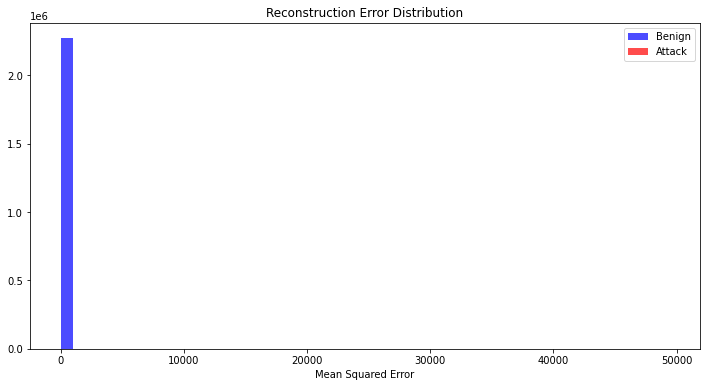

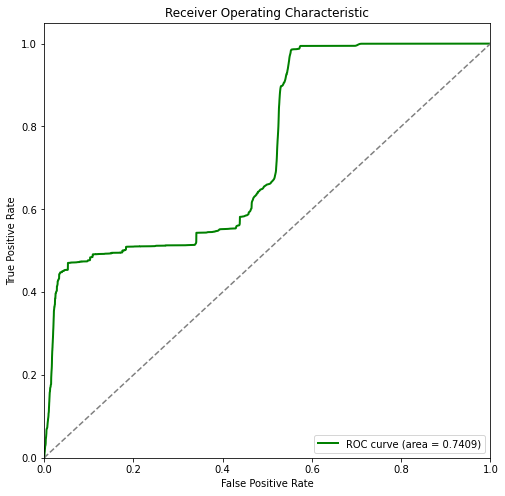

In [5]:
## Reconstruction Error
from sklearn.metrics import roc_curve, auc

benign_mse = np.mean(np.power(benign_data - benign_pred, 2), axis=1)
attack_mse = np.mean(np.power(attack_data - attack_pred, 2), axis=1)

plt.figure(figsize=(12, 6))
# sns.histplot(benign_mse.flatten(), bins=50, kde=True, color='blue', label='Benign')
# sns.histplot(attack_mse.flatten(), bins=50, kde=True, color='red', label='Attack')
plt.hist(benign_mse, bins=50, color='blue', alpha=0.7, label='Benign')
plt.hist(attack_mse, bins=50, color='red', alpha=0.7, label='Attack')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Squared Error')
plt.show()

## ROC curve
true_labels = np.concatenate([np.zeros(len(benign_mse)), np.ones(len(attack_mse))])
pred_scores = np.concatenate([benign_mse, attack_mse])

fpr, tpr, thresholds = roc_curve(true_labels, pred_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [6]:

import ipaddress
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import scikeras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
import time

def convert_ip2int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return 0  # Return 0 for invalid IP addresses    

def preprocess_data(data):
    df = data.copy()
    df.columns = df.columns.str.strip().str.replace('[ /]', '_', regex=True)
    
    df['Source_IP'] = df['Source_IP'].apply(convert_ip2int)
    df['Destination_IP'] = df['Destination_IP'].apply(convert_ip2int)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce').astype(np.int64)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    y = np.where(df['Label'] == 'BENIGN', 0, 1)
    X = df.drop('Label', axis=1)
    X = X.select_dtypes(include=np.number)
    return X, y


In [7]:
X, y = preprocess_data(pd.concat([benign_df, attack_df], ignore_index=True))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(f"Train 데이터 크기: {X_train.shape}")
print(f"Test 데이터 크기: {X_test.shape}")
print("-" * 50)

Train 데이터 크기: (2262300, 83)
Test 데이터 크기: (565576, 83)
--------------------------------------------------


In [8]:
## RF
print("Random Forest 모델 학습 시작...")
RF_starttime = time.time()
RF_model = RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_leaf=5, random_state=42)
RF_model.fit(X_train, y_train)
RF_endtime = time.time()
RF_time = RF_endtime - RF_starttime
print("Random Forest 모델 학습 완료.")

y_pred_RF = RF_model.predict(X_test)
accuracy_RF = accuracy_score(y_test, y_pred_RF)
recall_RF = recall_score(y_test, y_pred_RF)
f1_RF = f1_score(y_test, y_pred_RF)


Random Forest 모델 학습 시작...
Random Forest 모델 학습 완료.


In [9]:
## LSTM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

def create_lstm_model(lstm_units=100, dense_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(lstm_units, activation='relu',
        input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("LSTM 모델 학습 시작...")
LSTM_starttime = time.time()
lstm_model = KerasClassifier(build_fn=create_lstm_model)
lstm_model.fit(X_train_lstm, y_train, epochs=25, batch_size=32, verbose=1)
LSTM_endtime = time.time()
LSTM_time = LSTM_endtime - LSTM_starttime
print("LSTM 모델 학습 완료.")

y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype(int)
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
recall_lstm = recall_score(y_test, y_pred_lstm)
f1_lstm = f1_score(y_test, y_pred_lstm)



LSTM 모델 학습 시작...


c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
70697/70697 [==============================] - 318s 4ms/step - loss: 0.0064 - accuracy: 0.9986
Epoch 2/25
70697/70697 [==============================] - 316s 4ms/step - loss: 0.0038 - accuracy: 0.9992
Epoch 3/25
70697/70697 [==============================] - 316s 4ms/step - loss: 0.0033 - accuracy: 0.9993
Epoch 4/25
70697/70697 [==============================] - 315s 4ms/step - loss: 0.0032 - accuracy: 0.9993
Epoch 5/25
70697/70697 [==============================] - 314s 4ms/step - loss: 0.0030 - accuracy: 0.9993
Epoch 6/25
70697/70697 [==============================] - 314s 4ms/step - loss: 0.0030 - accuracy: 0.9993
Epoch 7/25
70697/70697 [==============================] - 313s 4ms/step - loss: 0.0034 - accuracy: 0.9994
Epoch 8/25
70697/70697 [==============================] - 313s 4ms/step - loss: 0.0050 - accuracy: 0.9994
Epoch 9/25
70697/70697 [==============================] - 314s 4ms/step - loss: 0.0044 - accuracy: 0.9994
Epoch 10/25
70697/70697 [=====================

In [10]:
## 모델 성능 비교
print("모델 성능 비교:")

print("[Random Forest]")
print(f"- 정확도: {accuracy_RF:.4f}")
print(f"- 재현율 (Recall): {recall_RF:.4f}")
print(f"- F1-Score: {f1_RF:.4f}")
print(f"- 학습 시간: {RF_time:.4f}초")
print("성능 리포트:")
print(classification_report(y_test, y_pred_RF, target_names=['BENIGN (0)', 'ATTACK (1)']))
print("-" * 50)

print("[LSTM]")
print(f"- 정확도: {accuracy_lstm:.4f}")
print(f"- 재현율 (Recall): {recall_lstm:.4f}")
print(f"- F1-Score: {f1_lstm:.4f}")
print(f"- 학습 시간: {LSTM_time:.4f}초")
print("성능 리포트:")
print(classification_report(y_test, y_pred_lstm, target_names=['BENIGN (0)', 'ATTACK (1)']))
print("-" * 50)

모델 성능 비교:
[Random Forest]
- 정확도: 1.0000
- 재현율 (Recall): 0.9999
- F1-Score: 0.9999
- 학습 시간: 630.5666초
성능 리포트:
              precision    recall  f1-score   support

  BENIGN (0)       1.00      1.00      1.00    453971
  ATTACK (1)       1.00      1.00      1.00    111605

    accuracy                           1.00    565576
   macro avg       1.00      1.00      1.00    565576
weighted avg       1.00      1.00      1.00    565576

--------------------------------------------------
[LSTM]
- 정확도: 0.9995
- 재현율 (Recall): 0.9996
- F1-Score: 0.9988
- 학습 시간: 7923.5740초
성능 리포트:
              precision    recall  f1-score   support

  BENIGN (0)       1.00      1.00      1.00    453971
  ATTACK (1)       1.00      1.00      1.00    111605

    accuracy                           1.00    565576
   macro avg       1.00      1.00      1.00    565576
weighted avg       1.00      1.00      1.00    565576

--------------------------------------------------


17675/17675 [==============================] - 24s 1ms/step


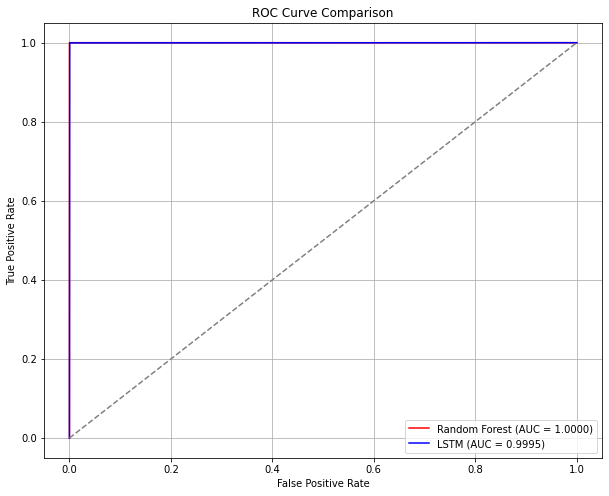

In [11]:
## ROC Curve

y_pred_prob_RF = RF_model.predict_proba(X_test)[:, 1]
y_pred_prob_lstm = lstm_model.predict(X_test_lstm)

fpr_RF, tpr_RF, _ = roc_curve(y_test, y_pred_prob_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)
plt.figure(figsize=(10, 8))
plt.plot(fpr_RF, tpr_RF, color='red', label='Random Forest (AUC = {:.4f})'.format(roc_auc_RF))

fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_prob_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, color='blue', label='LSTM (AUC = {:.4f})'.format(roc_auc_lstm))

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

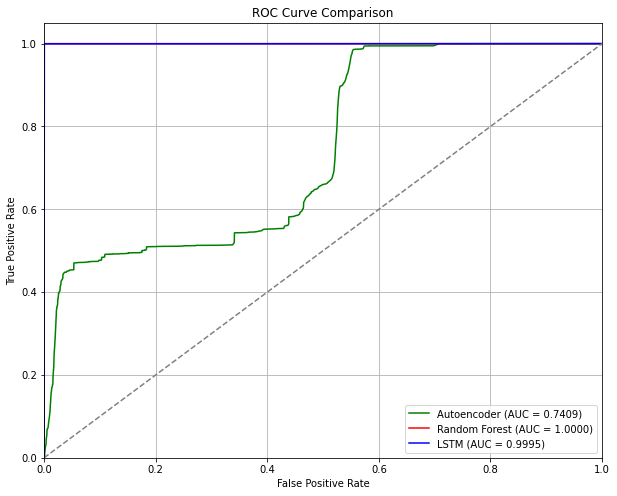

In [12]:
## ROC curve for every model

plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, color='green', label='Autoencoder (AUC = {:.4f})'.format(roc_auc))
plt.plot(fpr_RF, tpr_RF, color='red', label='Random Forest (AUC = {:.4f})'.format(roc_auc_RF))
plt.plot(fpr_lstm, tpr_lstm, color='blue', label='LSTM (AUC = {:.4f})'.format(roc_auc_lstm))

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

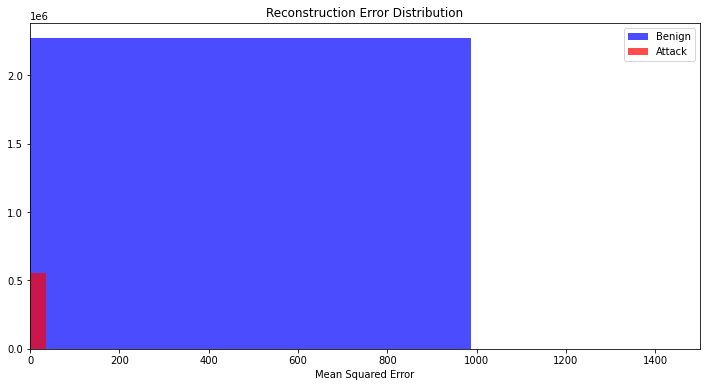

In [20]:
plt.figure(figsize=(12, 6))
# sns.histplot(benign_mse.flatten(), bins=50, kde=True, color='blue', label='Benign')
# sns.histplot(attack_mse.flatten(), bins=50, kde=True, color='red', label='Attack')
plt.hist(benign_mse, bins=50, color='blue', alpha=0.7, label='Benign')
plt.hist(attack_mse, bins=50, color='red', alpha=0.7, label='Attack')
plt.xlim(0,1500)
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Squared Error')
plt.show()

17675/17675 [==============================] - 23s 1ms/step


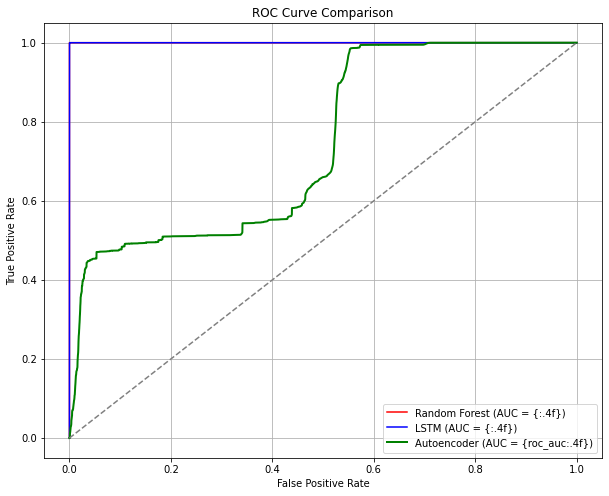

In [19]:
y_pred_prob_RF = RF_model.predict_proba(X_test)[:, 1]
y_pred_prob_lstm = lstm_model.predict_proba(X_test_lstm)[:, 1]

fpr_RF, tpr_RF, _ = roc_curve(y_test, y_pred_prob_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)
plt.figure(figsize=(10, 8))
plt.plot(fpr_RF, tpr_RF, color='red', label='Random Forest (AUC = {:.4f})')

fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_prob_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, color='blue', label='LSTM (AUC = {:.4f})')
plt.plot(fpr, tpr, color='green', lw=2, label='Autoencoder (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()